In [2]:
import pandas as pd


# Chargement du dataset nettoyé
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/projet_IA/df_clean.csv")
print(df.head())



Mounted at /content/drive
    id       MMSI         BaseDateTime       LAT       LON   SOG    COG  \
0   82  636017833  2023-05-29 00:00:06  29.07019 -89.29958  13.4  227.6   
1  255  255805583  2023-05-29 00:00:02  28.86110 -95.15923   0.1   39.9   
2  378  319963000  2023-05-29 00:00:06  29.74962 -95.09580   0.0   91.6   
3  400  538007204  2023-05-29 00:00:01  29.19717 -94.49920  12.8  131.0   
4  446  538005585  2023-05-29 00:00:09  29.53872 -93.76808   6.2   19.0   

   Heading    VesselName         IMO  ... VesselType  Status  Length  Width  \
0      227   STOLT LOTUS  IMO9617648  ...         80       0     183     28   
1       64    CHEM SEA 1  IMO9731729  ...         80       1     160     25   
2       47  STOLT ISLAND  IMO9414058  ...         80       5     182     32   
3      131          GWEN  IMO9407067  ...         80       0     144     24   
4       26   UACC MIRDIF  IMO9402794  ...         80       0     182     32   

   Draft  Cargo  TransceiverClass            Sta

In [4]:
# Exemple de sélection — à adapter selon les colonnes réelles du dataset
cols_to_keep = ['LAT', 'LON', 'SOG', 'COG', 'Heading', 'VesselType']
df_selected = df[cols_to_keep]

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Définir colonnes numériques et catégorielles
num_features = ['SOG', 'COG', 'Heading']
cat_features = ['VesselType']  # et 'Cargo' si propre

# Préprocesseur
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(), cat_features)
])

# Transformer les données
X = preprocessor.fit_transform(df_selected)
# Accès direct au OneHotEncoder dans le transformer 'cat'

encoder = preprocessor.named_transformers_['cat']
print("Catégories connues pour chaque variable catégorielle :")
print(encoder.categories_)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Tu peux regrouper ça dans ton pipeline
X = df[num_features + cat_features]
X_transformed = preprocessor.fit_transform(X)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)

plt.scatter(X_pca[:, 0], X_pca[:, 1], s=3)
plt.title("Projection PCA des données navires")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Catégories connues pour chaque variable catégorielle :
[array([60, 61, 70, 71, 74, 79, 80, 82, 84, 89])]
(169566, 4)


NameError: name 'plt' is not defined

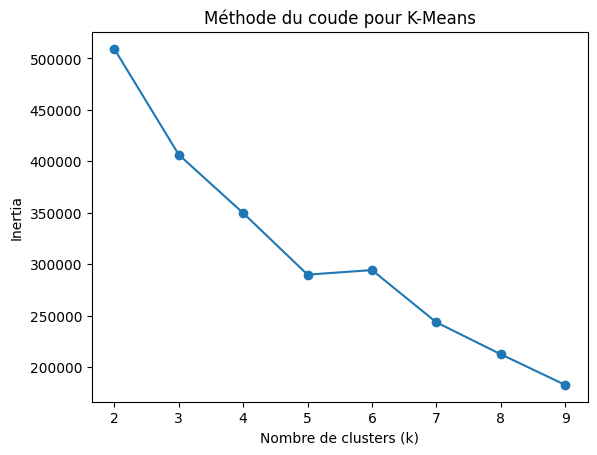

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Normalisation des données (important pour K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Détermination du nombre optimal de clusters avec la méthode du coude
inertia = []
cluster_range = range(2, 10)  # On teste de 2 à 10 clusters
for k in cluster_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertia.append(model.inertia_)

# Visualisation de la méthode du coude
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertia")
plt.title("Méthode du coude pour K-Means")
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Expérimenter avec un nombre de clusters
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X)
df_selected.loc[:, 'Cluster'] = labels

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

print("Silhouette Score:", silhouette_score(X, labels))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X, labels))
print("Davies-Bouldin Index:", davies_bouldin_score(X, labels))


Silhouette Score: 0.47813009993083383
Calinski-Harabasz Index: 150156.20023957614
Davies-Bouldin Index: 0.7224132851270275


In [ ]:
import plotly.express as px

fig = px.scatter_mapbox(df_selected,
                        lat="LAT",
                        lon="LON",
                        color="Cluster",
                        hover_data=["VesselType", "SOG", "COG"],
                        zoom=3,
                        height=600)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


In [ ]:
import numpy as np
import pandas as pd
import joblib

# Chargement du modèle et du préprocesseur
model = joblib.load("model.pkl")  # Le modèle KMeans entraîné sur les colonnes numériques uniquement

# Liste des colonnes utilisées pour l'entraînement
num_features = ['LAT', 'LON', 'SOG', 'COG']  # adapte si ton modèle n'en prend que 4
# Ex: num_features = ['LAT', 'LON', 'SOG', 'COG'] si 'Heading' n'est pas inclus

def predict_cluster_interactif():
    print("📡 Prédiction de cluster pour un navire\n")

    try:
        lat = float(input("LAT (latitude) : "))
        lon = float(input("LON (longitude) : "))
        sog = float(input("SOG (Speed Over Ground) : "))
        cog = float(input("COG (Course Over Ground) : "))
    except ValueError:
        print("❌ Entrée invalide : les valeurs numériques doivent être valides.")
        return

    # Créer dictionnaire avec les données du navire
    navire = {
        "LAT": lat,
        "LON": lon,
        "SOG": sog,
        "COG": cog,
    }

    # Transformation en DataFrame
    df_input = pd.DataFrame([navire])

    # Sélection des colonnes que le modèle attend
    try:
        X_input = df_input[num_features]  # s'assure que les colonnes sont dans le bon ordre
        cluster = model.predict(X_input)[0]
        print(f"\n✅ Ce navire appartient au cluster : {cluster}")
    except Exception as e:
        print(f"❌ Erreur pendant la prédiction : {e}")

predict_cluster_interactif()

📡 Prédiction de cluster pour un navire

LAT (latitude) : 29.07019
LON (longitude) : -89.29958
SOG (Speed Over Ground) : 13.4
COG (Course Over Ground) : 227.6

✅ Ce navire appartient au cluster : 2
